In [447]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [448]:
import geopandas as gpd
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd

import pandapower as pp
import random
import math
import secrets

In [449]:
micropolis_folder = Path('../dreaminsg_integrated_model/data/networks/micropolis/gis')

# Micropolis Power Network Generation
## Buses

In [450]:
micropolis_buses = gpd.read_file(micropolis_folder/'all_buses.shp', encoding="utf-8")
micropolis_buses['x'] = micropolis_buses.centroid.x
micropolis_buses['y'] = micropolis_buses.centroid.y

bus_vn_kv_dict = {'Feeder1 buses': 13.8,
                  'Overhead distribution buses': 13.8,
                  'Feeder2_buses': 13.8,
                  'Underground distribution buses': 13.8,
                  }

micropolis_buses["vn_kv"] = micropolis_buses["layer"].apply(lambda x: bus_vn_kv_dict.get(x))

del micropolis_buses['path']
del micropolis_buses['geometry']
#micropolis_buses.FID = micropolis_buses.FID.astype(int)
micropolis_buses.head()

ipykernel_launcher:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

ipykernel_launcher:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



,FID,layer,Switches,x,y,vn_kv
0,54,Feeder1 buses,49,5426.421856,4000.618975,13.8
1,55,Feeder1 buses,49,5209.765439,3997.432851,13.8
2,56,Feeder1 buses,49,4967.620031,4003.805099,13.8
3,0,Feeder1 buses,"268,5,SS",4887.568671,3218.823850,13.8
4,1,Feeder1 buses,"268,5,SS",4787.205771,3218.823850,13.8


In [451]:
micropolis_buses.vn_kv.unique()

array([13.8])

In [452]:
pn = pp.create_empty_network(
    name="sample_network", f_hz=50.0, sn_mva=1, add_stdtypes=True
)

In [453]:
buses = dict()
for index, row in micropolis_buses.iterrows():
    x, y = row.x, row.y
    buses[f'bus{row.FID}'] = pp.create_bus(pn, vn_kv=row['vn_kv'], name=f'P_B{row.FID}', geodata=(x, y), type="b")

#Substation bus
buses[f'bus_Substation_ext'] = pp.create_bus(pn, vn_kv=138, name=f'P_B1000', geodata=(4911,3181), type="b")
buses[f'bus_Substation'] = pp.create_bus(pn, vn_kv=13.8, name=f'P_B1001', geodata=(4906,3181), type="b")

###  External grid

In [454]:
pp.create_ext_grid(pn, buses['bus_Substation_ext'], name="P_EG1", s_sc_max_mva=1000, rx_max=.1, x0x_max=1.0, r0x0_max=0.1)

0

## Lines, Transformers, and Switches

In [455]:
micropolis_links = gpd.read_file(micropolis_folder/'combined_lines.shp', encoding="utf-8")
micropolis_links.id = micropolis_links.id.values.astype(int)

### Lines

In [456]:
micropolis_lines = micropolis_links[micropolis_links.layer.isin(['Feeder1_lines', 'Feeder2_lines', 'Overhead lines', 'Underground lines'])]
micropolis_lines.head()

,id,from,to,Voltage,layer,path,sublayer,geometry
0,1,0,1,13.8 KV,Feeder1_lines,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4887.569 3218.824, 4787.206 3218.824)"
1,2,1,2,13.8 KV,Feeder1_lines,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4787.206 3218.824, 4784.020 3402.026)"
2,3,2,3,13.8 KV,Feeder1_lines,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4784.020 3402.026, 4785.613 3601.159)"
3,4,3,4,13.8 KV,Feeder1_lines,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4785.613 3601.159, 4787.206 3766.837)"
6,7,6,7,13.8 KV,Feeder1_lines,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4788.799 4212.894, 4785.613 4421.586)"


In [457]:
def compute_distance(bus1, bus2):
    x1 = micropolis_buses[micropolis_buses.FID == int(bus1)].x.item()
    x2 = micropolis_buses[micropolis_buses.FID == int(bus2)].x.item()
    y1 = micropolis_buses[micropolis_buses.FID == int(bus1)].y.item()
    y2 = micropolis_buses[micropolis_buses.FID == int(bus2)].y.item()
    dist = math.hypot(x2 - x1, y2 - y1)/1000
    return dist

In [458]:
pp.create_std_type(pn, {'r0_ohm_per_km': 0.0848, 
                        'x0_ohm_per_km': 0.4649556, 
                        'c0_nf_per_km': 230.6,
                        'c_nf_per_km': 9.08, 
                        'r_ohm_per_km': 0.0653,
                        'x_ohm_per_km': 0.398, 
                        'max_i_ka': 1.14,
                        'type': 'ol'}, 
                     name="micropolis_line")

micropolis_line = 'micropolis_line'
#micropolis_line  = '15-AL1/3-ST1A 0.4'

In [459]:
for i, row in micropolis_lines.iterrows():
    pp.create_line(pn, 
                    from_bus = buses['bus{}'.format(row['from'])], 
                    to_bus = buses['bus{}'.format(row['to'])], 
                    length_km = compute_distance(row['from'], row['to']), 
                    std_type=micropolis_line, 
                    name= 'P_L{}'.format(row['id']), 
                    #index = i,
                    )

In [460]:
pn.line.head()

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,P_L1,micropolis_line,3,4,0.100363,0.0653,0.398,9.08,0.0,1.14,1.0,1,ol,True
1,P_L2,micropolis_line,4,5,0.183230,0.0653,0.398,9.08,0.0,1.14,1.0,1,ol,True
2,P_L3,micropolis_line,5,6,0.199139,0.0653,0.398,9.08,0.0,1.14,1.0,1,ol,True
3,P_L4,micropolis_line,6,7,0.165686,0.0653,0.398,9.08,0.0,1.14,1.0,1,ol,True
4,P_L7,micropolis_line,9,10,0.208715,0.0653,0.398,9.08,0.0,1.14,1.0,1,ol,True


### Switches

In [461]:
micropolis_switches = micropolis_links[micropolis_links.layer == 'Transformers and Switches']
micropolis_switches.head()

,id,from,to,Voltage,layer,path,sublayer,geometry
4,5,4,5,13.8 KV,Transformers and Switches,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4787.206 3766.837, 4785.613 4001.814)"
5,6,5,6,13.8 KV,Transformers and Switches,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4785.613 4001.814, 4788.799 4212.894)"
8,9,8,9,13.8 KV,Transformers and Switches,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4785.613 4617.532, 4785.613 4797.548)"
12,16,9,10,13.8 KV,Transformers and Switches,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4785.613 4797.548, 4587.277 4796.752)"
13,20,9,25,13.8 KV,Transformers and Switches,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4785.613 4797.548, 5014.217 4795.159)"


In [462]:
switches = dict()
for i, row in micropolis_switches.iterrows():

    #create switch buses
    switch_bus = micropolis_buses[micropolis_buses['FID'] == int(row['from'])]
    buses['busS{}'.format(row['from'])] = pp.create_bus(pn, 
                                                vn_kv=switch_bus['vn_kv'], 
                                                name='P_B{}S'.format(row['id']), 
                                                geodata=(switch_bus.x.item(), switch_bus.y.item()), 
                                                type="b")
    
    #create switches
    switches['switch{}'.format(row.id)] = pp.create_switch(
        pn, 
        buses['bus{}'.format(row['from'])], 
        buses['busS{}'.format(row['from'])], 
        et="b", 
        type="CB", 
        closed=True, 
        name="P_S{}".format(row['id'])
    )

    #switch_bus to bus line
    pp.create_line(pn, 
                    from_bus = buses['busS{}'.format(row['from'])], 
                    to_bus = buses['bus{}'.format(row['to'])], 
                    length_km = compute_distance(row['from'], row['to']), 
                    std_type=micropolis_line, 
                    name= 'P_L{}S'.format(row['id']),
                    )
#Substation breakers
switches['switch_Feeder1'] = pp.create_switch(
        pn, 
        buses['bus_Substation'], 
        buses['bus0'], 
        et="b", 
        type="CB", 
        closed=True,
        name="P_S2001"
)
switches['switch_Feeder2'] = pp.create_switch(
        pn, 
        buses['bus_Substation'], 
        buses['bus60'], 
        et="b", 
        type="CB", 
        closed=True, 
        name="P_S2002"
)

In [463]:
pn.switch.head()

,bus,element,et,type,closed,name,z_ohm
0,7,378,b,CB,True,P_S5,0.0
1,8,379,b,CB,True,P_S6,0.0
2,11,380,b,CB,True,P_S9,0.0
3,12,381,b,CB,True,P_S16,0.0
4,12,382,b,CB,True,P_S20,0.0


In [464]:
micropolis_offswitches = micropolis_links[micropolis_links.layer == 'Off Switch']
micropolis_offswitches.head()

,id,from,to,Voltage,layer,path,sublayer,geometry
27,36,40,41,13.8 KV,Off Switch,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,9.0,"LINESTRING (5589.312 4227.232, 5590.905 3997.831)"
280,297,73,13,None,Off Switch,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (3794.330 4796.353, 3989.878 4796.752)"
313,330,321,322,None,Off Switch,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (1809.375 3998.229, 1569.969 3998.8..."


In [465]:
for i, row in micropolis_offswitches.iterrows():

    #create switch buses
    switch_bus = micropolis_buses[micropolis_buses['FID'] == int(row['from'])]
    buses['busS{}'.format(row['from'])] = pp.create_bus(pn, 
                                                vn_kv=switch_bus['vn_kv'], 
                                                name='P_B{}S'.format(row['id']), 
                                                geodata=(switch_bus.x.item(), switch_bus.y.item()), 
                                                type="b")
    
    #create switches
    switches['switch{}'.format(row.id)] = pp.create_switch(
        pn, 
        buses['bus{}'.format(row['from'])], 
        buses['busS{}'.format(row['from'])], 
        et="b", 
        type="CB", 
        closed=False, 
        name="P_S{}".format(row['id'])
    )

    #switch_bus to bus line
    pp.create_line(pn, 
                    from_bus = buses['busS{}'.format(row['from'])], 
                    to_bus = buses['bus{}'.format(row['to'])], 
                    length_km = compute_distance(row['from'], row['to']), 
                    std_type=micropolis_line, 
                    name= 'P_L{}S'.format(row['id']),
                    )

## Loads

In [466]:
micropolis_buildings = gpd.read_file(micropolis_folder/'buildings_v1.shp', encoding="utf-8")
print(micropolis_buildings.shape)
micropolis_buildings.head()

(868, 12)


,FACILITY_T,AREA,OHC,EF,CCN,HEIGHT,POP,ID,BUILDING_C,Category,Centroid,geometry
0,Single Family Re,1502.34,7,1.5,1.0,14.0,1,1,114177.84,None,"3852,4329","POLYGON ((3870.889 4364.112, 3870.782 4349.179..."
1,Single Family Re,1534.68,7,1.5,1.0,14.0,1,2,116635.68,None,"3266,4061","POLYGON ((3240.796 4076.466, 3291.150 4076.466..."
2,Single Family Re,1512.22,7,1.0,1.0,14.0,2,3,114928.72,None,"3543,4082","POLYGON ((3525.126 4101.208, 3565.210 4101.155..."
3,Single Family Re,1502.34,7,1.0,1.0,14.0,6,4,114177.84,None,"3399,4345","POLYGON ((3380.307 4310.097, 3380.549 4325.028..."
4,Single Family Re,1502.34,7,1.0,1.0,14.0,5,5,114177.84,None,"3249,4504","POLYGON ((3267.023 4539.468, 3267.034 4524.535..."


In [467]:
micropolis_hub_dist = gpd.read_file(micropolis_folder/'Hub distance.shp', encoding="utf-8")
micropolis_hub_dist1 = micropolis_hub_dist.loc[:, ['ID', 'HubName', 'HubDist']]

In [468]:
micropolis_buildings= pd.merge(micropolis_buildings, micropolis_hub_dist1, left_on = 'ID', right_on = 'ID', how = 'inner')
#del micropolis_buildings['geometry']
print(micropolis_buildings.shape)
micropolis_buildings.head()

(802, 14)


,FACILITY_T,AREA,OHC,EF,CCN,HEIGHT,POP,ID,BUILDING_C,Category,Centroid,geometry,HubName,HubDist
0,Single Family Re,1502.34,7,1.5,1.0,14.0,1,1,114177.84,None,"3852,4329","POLYGON ((3870.889 4364.112, 3870.782 4349.179...",347,97.180446
1,Single Family Re,1534.68,7,1.5,1.0,14.0,1,2,116635.68,None,"3266,4061","POLYGON ((3240.796 4076.466, 3291.150 4076.466...",317,100.337214
2,Single Family Re,1512.22,7,1.0,1.0,14.0,2,3,114928.72,None,"3543,4082","POLYGON ((3525.126 4101.208, 3565.210 4101.155...",316,NaN
3,Single Family Re,1502.34,7,1.0,1.0,14.0,6,4,114177.84,None,"3399,4345","POLYGON ((3380.307 4310.097, 3380.549 4325.028...",325,102.018284
4,Single Family Re,1502.34,7,1.0,1.0,14.0,5,5,114177.84,None,"3249,4504","POLYGON ((3267.023 4539.468, 3267.034 4524.535...",325,114.257383


In [469]:
micropolis_power_details = pd.read_csv(micropolis_folder/'building_power_details.csv')
micropolis_power_details.head()

,building,type,Pabc,Qabc,voltage,phases
0,Apartment,Residential,90,0,120,1
1,Auto Parts Resel,Industrial,30,0,208,3
2,Bar,CBD,30,0,208,3
3,Bookstore,CBD,30,0,208,3
4,Church,Church,250,0,208,3


In [470]:
micropolis_buildings= pd.merge(micropolis_buildings, micropolis_power_details, left_on = 'FACILITY_T', right_on = 'building', how = 'inner')
del micropolis_buildings['building']
print(micropolis_buildings.shape)
micropolis_buildings.head()

(788, 19)


,FACILITY_T,AREA,OHC,EF,CCN,HEIGHT,POP,ID,BUILDING_C,Category,Centroid,geometry,HubName,HubDist,type,Pabc,Qabc,voltage,phases
0,Single Family Re,1502.34,7,1.5,1.0,14.0,1,1,114177.84,None,"3852,4329","POLYGON ((3870.889 4364.112, 3870.782 4349.179...",347,97.180446,Residential,20,0,120,1
1,Single Family Re,1534.68,7,1.5,1.0,14.0,1,2,116635.68,None,"3266,4061","POLYGON ((3240.796 4076.466, 3291.150 4076.466...",317,100.337214,Residential,20,0,120,1
2,Single Family Re,1512.22,7,1.0,1.0,14.0,2,3,114928.72,None,"3543,4082","POLYGON ((3525.126 4101.208, 3565.210 4101.155...",316,NaN,Residential,20,0,120,1
3,Single Family Re,1502.34,7,1.0,1.0,14.0,6,4,114177.84,None,"3399,4345","POLYGON ((3380.307 4310.097, 3380.549 4325.028...",325,102.018284,Residential,20,0,120,1
4,Single Family Re,1502.34,7,1.0,1.0,14.0,5,5,114177.84,None,"3249,4504","POLYGON ((3267.023 4539.468, 3267.034 4524.535...",325,114.257383,Residential,20,0,120,1


In [471]:
switch_list = list(micropolis_buses.Switches.unique())
#phase_list = [1,2,3]
phase_loads = [0,0,0]
phase_dict = dict()

for switch_comb in switch_list:
    #print(switch_comb)
    #phase_dict[switch] = secrets.choice(phase_list)
    buses_using_switch_comb = list(micropolis_buses[micropolis_buses['Switches'] == switch_comb]['FID'].unique())
    buses_using_switch_comb = [str(bus) for bus in buses_using_switch_comb]
    #print(buses_using_switch_comb)
    buildings_using_switch_comb_1p = micropolis_buildings.loc[(micropolis_buildings['HubName'].isin(buses_using_switch_comb)) & (micropolis_buildings['phases'] == 1), :]
    #print(buildings_using_switch_comb_1p)
    tot_load_on_switch_comb = buildings_using_switch_comb_1p['Pabc'].sum()
    #print(tot_load_on_switch_comb)

    phase_to_load = phase_loads.index(min(phase_loads))
    phase_loads[phase_to_load] += tot_load_on_switch_comb
    phase_dict[switch_comb] = phase_to_load

print(phase_loads)
print(phase_dict)

[5690, 5200, 5870]
{'49': 0, '268,5,SS': 0, '6,49,5': 1, '6,9,269': 1, '16,307,20,9': 1, '303,16': 1, '307': 2, '20,23': 0, '24,288,33,23': 1, '24': 1, '33,285,284': 0, '33,285': 0, '268': 0, '267': 1, '266': 0, '60,SS,299': 2, '60,SS': 2, '300,60,61,305': 2, '61,64,301': 2, '61,64': 2, '65,302,64,303': 2, '303,297': 2, '65': 2, '394': 1, '270': 2, '308': 2, '272': 2, '271': 2, '274': 2, '273': 2, '276': 2, '277': 2, '278': 2, '280': 2, '283': 2, '284': 2, '286': 0, '287': 2, '269,285': 1, '288': 0, '289': 1, '290': 2, '291': 0, '292': 1, '293': 2, '294': 0, '295': 1, '296': 2, '304': 0, '279': 1, '281': 1, '282': 1, '275': 1, '298': 1, '299': 0, '300': 1, '301': 0, '302': 2, '305': 1, '385': 1, '386': 1}


In [472]:
micropolis_buildings.Pabc.sum()

23930

In [473]:
A = 0
B = 0
C = 0
for i, row in micropolis_buildings.iterrows():
    coord = row['Centroid']
    x, y = coord.split(',')
    x, y = float(x), float(y)

    load_switch = micropolis_buses[micropolis_buses.FID == int(row['HubName'])].Switches.item()
    phase = phase_dict[load_switch]

    buses[f'busL{row.HubName}'] = pp.create_bus(pn, 
                                          vn_kv=row['voltage']/1000, 
                                          name=f'P_B{row.HubName}L', 
                                          geodata=(x, y), 
                                          type="b")
    
    if row['phases'] == 1:
      pp.create_transformer_from_parameters(pn, 
                                          hv_bus=buses[f'bus{row.HubName}'], 
                                          lv_bus=buses[f'busL{row.HubName}'], 
                                          sn_mva= row['Pabc']*3.6, 
                                          vn_hv_kv= 13.8, 
                                          vn_lv_kv= row['voltage']/1000, 
                                          vk_percent= 6, 
                                          vkr_percent= 0.78125, 
                                          pfe_kw= 2.7, 
                                          i0_percent= 0.16875, 
                                          shift_degree= 0, 
                                          tap_side= 'lv',
                                          tap_neutral= 0,
                                          tap_min= -2, 
                                          tap_max= 2,
                                          tap_step_degree= 0,
                                          tap_step_percent= 2.5,
                                          tap_phase_shifter= False,
                                          vk0_percent= 6, 
                                          vkr0_percent= 0.78125, 
                                          mag0_percent= 100, 
                                          mag0_rx= 0.,
                                          si0_hv_partial= 0.9,
                                          vector_group= "Dyn",
                                          parallel=1,
                                          tap_pos=0,
                                          index=pp.get_free_id(pn.trafo)+1,
                                        )


      if phase == 0:
        A += row['Pabc']
        pp.create_asymmetric_load(pn, 
                                  buses[f'busL{row.HubName}'], 
                                  p_a_mw=row['Pabc']/1000, 
                                  p_b_mw=0, 
                                  p_c_mw=0, 
                                  type="wye",
                                  name = 'P_LO{}'.format(row['ID']))
      elif phase == 1:
        B += row['Pabc']
        pp.create_asymmetric_load(pn, 
                                  buses[f'busL{row.HubName}'], 
                                  p_a_mw=0, 
                                  p_b_mw=row['Pabc']/1000, 
                                  p_c_mw=0, 
                                  type="wye",
                                  name = 'P_LO{}'.format(row['ID']))
      elif phase == 2:
        C += row['Pabc']
        pp.create_asymmetric_load(pn, 
                                  buses[f'busL{row.HubName}'], 
                                  p_a_mw=0, 
                                  p_b_mw=0, 
                                  p_c_mw=row['Pabc']/1000, 
                                  type="wye",
                                  name = 'P_LO{}'.format(row['ID']))

    elif row['phases'] == 3:
      A += row['Pabc']/3
      B += row['Pabc']/3
      C += row['Pabc']/3
      pp.create_transformer_from_parameters(pn, 
                                          hv_bus=buses[f'bus{row.HubName}'], 
                                          lv_bus=buses[f'busL{row.HubName}'], 
                                          sn_mva= row['Pabc']*1.2, 
                                          vn_hv_kv= 13.8, 
                                          vn_lv_kv= row['voltage']/1000, 
                                          vk_percent= 6, 
                                          vkr_percent= 0.78125, 
                                          pfe_kw= 2.7, 
                                          i0_percent= 0.16875, 
                                          shift_degree= 0, 
                                          tap_side= 'lv',
                                          tap_neutral= 0,
                                          tap_min= -2, 
                                          tap_max= 2,
                                          tap_step_degree= 0,
                                          tap_step_percent= 2.5,
                                          tap_phase_shifter= False,
                                          vk0_percent= 6, 
                                          vkr0_percent= 0.78125, 
                                          mag0_percent= 100, 
                                          mag0_rx= 0.,
                                          si0_hv_partial= 0.9,
                                          vector_group= "Dyn",
                                          parallel=1,
                                          tap_pos=0,
                                          index=pp.get_free_id(pn.trafo)+1,
                                        )
      # pp.create_load(pn, 
      #                buses[f'busL{row.HubName}'], 
      #                p_mw=row['Pabc']/1000, 
      #                q_mvar=row['Qabc']/1000, 
      #                scaling=1, 
      #                name = 'P_LO{}'.format(row['ID']))
      pp.create_asymmetric_load(pn, 
                                  buses[f'busL{row.HubName}'], 
                                  p_a_mw=row['Pabc']/3000, 
                                  p_b_mw=row['Pabc']/3000, 
                                  p_c_mw=row['Pabc']/3000, 
                                  type="wye",
                                  name = 'P_LO{}'.format(row['ID']))


pp.create_transformer_from_parameters(pn, 
                                          hv_bus=buses['bus_Substation_ext'], 
                                          lv_bus=buses['bus_Substation'], 
                                          sn_mva= 25, 
                                          vn_hv_kv= 138, 
                                          vn_lv_kv= 13.8, 
                                          vk_percent= 6, 
                                          vkr_percent= 0.78125, 
                                          pfe_kw= 2.7, 
                                          i0_percent= 0.16875, 
                                          shift_degree= 0, 
                                          tap_side= 'lv',
                                          tap_neutral= 0,
                                          tap_min= -2, 
                                          tap_max= 2,
                                          tap_step_degree= 0,
                                          tap_step_percent= 2.5,
                                          tap_phase_shifter= False,
                                          vk0_percent= 6, 
                                          vkr0_percent= 0.78125, 
                                          mag0_percent= 100, 
                                          mag0_rx= 0.,
                                          si0_hv_partial= 0.9,
                                          vector_group= "Dyn",
                                          parallel=1,
                                          tap_pos=0,
                                          index=pp.get_free_id(pn.trafo)+1,
                                        )

1577

In [474]:
print("Phase 1: ", round(A,2), "\tPhase 2: ", round(B,2), "\tPhase 3: ", round(C,2), "\tTotal: ", round(A+B+C,2))

Phase 1:  8080.0 	Phase 2:  7590.0 	Phase 3:  8260.0 	Total:  23930.0


In [475]:
pp.diagnostic(pn)



_____________ PANDAPOWER DIAGNOSTIC TOOL _____________ 


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------

_____________ END OF PANDAPOWER DIAGNOSTIC _____________ 


{}

<Figure size 3600x2520 with 0 Axes>

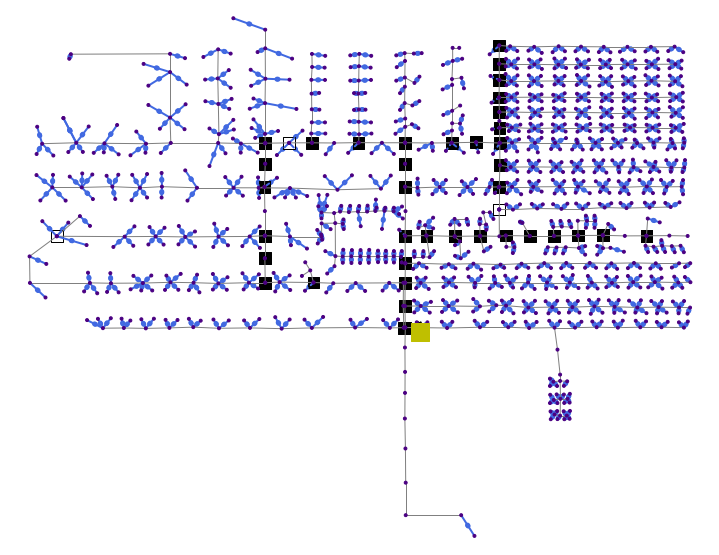

<AxesSubplot:>

In [476]:
import pandapower as pp
import pandapower.plotting as pandaplot
import matplotlib.pyplot as plt

options = {
        "bus_size": 0.25,
        "plot_loads": True,
        "library": "networkx",
        "bus_color": "indigo",
        "switch_color": 'green',
        "trafo_color": 'royalblue',
        "load_size": 0.5, 
        "show_plot": True,
        "scale_size": True,
        "trafo_size": 0.25
    }
plt.figure(1, figsize=(50, 35))
pandaplot.simple_plot(pn, **options)

In [489]:
pn.switch.at[switches['switch302'], "closed"] = False
pn.switch.at[switches['switch305'], "closed"] = False

In [490]:

pp.add_zero_impedance_parameters(pn)
pp.runpp_3ph(pn)

C:\Users\srijith\anaconda3\envs\dreaminsg\lib\site-packages\pandapower\results_bus.py:54: RuntimeWarning: invalid value encountered in true_divide
  net["res_bus_3ph"]["unbalance_percent"] = np.abs(V012_pu[2, :]/V012_pu[1, :])*100
C:\Users\srijith\anaconda3\envs\dreaminsg\lib\site-packages\pandapower\auxiliary.py:835: RuntimeWarning: invalid value encountered in true_divide
  return np.conjugate(np.divide(S, V, out=np.zeros_like(S), where=V != 0))  # Return zero if div by zero


In [491]:
pn.asymmetric_load['total_consumption_ratio'] = pn.res_asymmetric_load_3ph.sum(axis = 1)/pn.asymmetric_load[['p_a_mw', 'p_b_mw', 'p_c_mw','q_a_mvar', 'q_b_mvar', 'q_c_mvar']].sum(axis = 1)
#pn.asymmetric_load.head()
pn.asymmetric_load.total_consumption_ratio.unique()

array([1., 0.])

In [492]:
pn.load['total_consumption_ratio'] = pn.res_load.sum(axis = 1)/pn.load[['p_mw', 'q_mvar']].sum(axis = 1)
pn.load.head()
print(pn.res_load.p_mw.unique())

[]


In [493]:
print('Total three phase demand: ', round(pn.res_load.sum(axis = 1).sum(),2), 'mw', '; Total single phase demand: ', round(pn.res_asymmetric_load_3ph.sum(axis = 1).sum(),2), 'mw')

Total three phase demand:  0.0 mw ; Total single phase demand:  20.74 mw


In [494]:
micropolis_buildings['power_consump_ratio'] = 'NA'
for index, row in micropolis_buildings.iterrows():
    if row['phases'] == 1:
        micropolis_buildings.loc[index, 'power_consump_ratio'] = pn.asymmetric_load[pn.asymmetric_load['name'] == 'P_LO{}'.format(row['ID'])]['total_consumption_ratio'].item()
    elif row['phases'] == 3:
        micropolis_buildings.loc[index, 'power_consump_ratio'] = pn.asymmetric_load[pn.asymmetric_load['name'] == 'P_LO{}'.format(row['ID'])]['total_consumption_ratio'].item()
        #micropolis_buildings.loc[index, 'power_consump_ratio'] = pn.load[pn.load['name'] == 'P_LO{}'.format(row['ID'])]['total_consumption_ratio'].item()
micropolis_buildings.head()

,FACILITY_T,AREA,OHC,EF,CCN,HEIGHT,POP,ID,BUILDING_C,Category,Centroid,geometry,HubName,HubDist,type,Pabc,Qabc,voltage,phases,power_consump_ratio
0,Single Family Re,1502.34,7,1.5,1.0,14.0,1,1,114177.84,None,"3852,4329","POLYGON ((3870.889 4364.112, 3870.782 4349.179...",347,97.180446,Residential,20,0,120,1,1.0
1,Single Family Re,1534.68,7,1.5,1.0,14.0,1,2,116635.68,None,"3266,4061","POLYGON ((3240.796 4076.466, 3291.150 4076.466...",317,100.337214,Residential,20,0,120,1,1.0
2,Single Family Re,1512.22,7,1.0,1.0,14.0,2,3,114928.72,None,"3543,4082","POLYGON ((3525.126 4101.208, 3565.210 4101.155...",316,NaN,Residential,20,0,120,1,1.0
3,Single Family Re,1502.34,7,1.0,1.0,14.0,6,4,114177.84,None,"3399,4345","POLYGON ((3380.307 4310.097, 3380.549 4325.028...",325,102.018284,Residential,20,0,120,1,1.0
4,Single Family Re,1502.34,7,1.0,1.0,14.0,5,5,114177.84,None,"3249,4504","POLYGON ((3267.023 4539.468, 3267.034 4524.535...",325,114.257383,Residential,20,0,120,1,1.0


In [495]:
micropolis_buildings.power_consump_ratio.unique()

array([1.0, 0.0], dtype=object)

In [496]:
micropolis_links.head()

,id,from,to,Voltage,layer,path,sublayer,geometry
0,1,0,1,13.8 KV,Feeder1_lines,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4887.569 3218.824, 4787.206 3218.824)"
1,2,1,2,13.8 KV,Feeder1_lines,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4787.206 3218.824, 4784.020 3402.026)"
2,3,2,3,13.8 KV,Feeder1_lines,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4784.020 3402.026, 4785.613 3601.159)"
3,4,3,4,13.8 KV,Feeder1_lines,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4785.613 3601.159, 4787.206 3766.837)"
4,5,4,5,13.8 KV,Transformers and Switches,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4787.206 3766.837, 4785.613 4001.814)"


In [497]:
micropolis_hub_dist

,FACILITY_T,AREA,OHC,EF,CCN,HEIGHT,POP,ID,BUILDING_C,Category,HubName,HubDist,geometry
0,Single Family Re,1502.34,7.0,1.5,1.0,14.0,1.0,1,114177.84,None,347,97.180446,"LINESTRING (3855.508 4329.246, 3801.499 4410.036)"
1,Single Family Re,1534.68,7.0,1.5,1.0,14.0,1.0,2,116635.68,None,317,100.337214,"LINESTRING (3265.973 4061.228, 3190.559 3995.043)"
2,Single Family Re,1502.34,7.0,1.0,1.0,14.0,6.0,4,114177.84,None,325,102.018284,"LINESTRING (3396.002 4344.823, 3319.598 4412.425)"
3,Single Family Re,1502.34,7.0,1.0,1.0,14.0,5.0,5,114177.84,None,325,114.257383,"LINESTRING (3251.919 4504.482, 3319.598 4412.425)"
4,Single Family Re,1502.34,7.0,1.5,1.0,14.0,2.0,6,0.00,None,74,91.730756,"LINESTRING (3505.037 4835.482, 3588.825 4872.820)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,Single Family Re,NaN,NaN,NaN,NaN,NaN,NaN,638,NaN,None,75,NaN,"LINESTRING (3589.248 5135.623, 3855.105 5080.7..."
798,Single Family Re,NaN,NaN,NaN,NaN,NaN,NaN,639,NaN,None,76,NaN,"LINESTRING (3591.715 5344.114, 3793.421 5337.3..."
799,Single Family Re,NaN,NaN,NaN,NaN,NaN,NaN,683,NaN,None,77,NaN,"LINESTRING (3591.715 5603.185, 3809.459 5513.1..."
800,Single Family Re,NaN,NaN,NaN,NaN,NaN,NaN,295,NaN,None,234,NaN,"LINESTRING (5692.680 5323.527, 5644.412 5384.1..."


In [498]:
micropolis_buildings

,FACILITY_T,AREA,OHC,EF,CCN,HEIGHT,POP,ID,BUILDING_C,Category,Centroid,geometry,HubName,HubDist,type,Pabc,Qabc,voltage,phases,power_consump_ratio
0,Single Family Re,1502.34,7,1.5,1.0,14.0,1,1,114177.84,None,"3852,4329","POLYGON ((3870.889 4364.112, 3870.782 4349.179...",347,97.180446,Residential,20,0,120,1,1.0
1,Single Family Re,1534.68,7,1.5,1.0,14.0,1,2,116635.68,None,"3266,4061","POLYGON ((3240.796 4076.466, 3291.150 4076.466...",317,100.337214,Residential,20,0,120,1,1.0
2,Single Family Re,1512.22,7,1.0,1.0,14.0,2,3,114928.72,None,"3543,4082","POLYGON ((3525.126 4101.208, 3565.210 4101.155...",316,NaN,Residential,20,0,120,1,1.0
3,Single Family Re,1502.34,7,1.0,1.0,14.0,6,4,114177.84,None,"3399,4345","POLYGON ((3380.307 4310.097, 3380.549 4325.028...",325,102.018284,Residential,20,0,120,1,1.0
4,Single Family Re,1502.34,7,1.0,1.0,14.0,5,5,114177.84,None,"3249,4504","POLYGON ((3267.023 4539.468, 3267.034 4524.535...",325,114.257383,Residential,20,0,120,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Apartment,6010.01,7,1.5,1.0,30.0,60,863,1036726.73,None,"4349,5078","POLYGON ((4323.852 5138.252, 4373.820 5138.252...",271,42.232725,Residential,90,0,120,1,1.0
784,Apartment,6010.01,7,1.5,1.0,30.0,60,864,0.00,None,"4317,5328","POLYGON ((4256.419 5302.802, 4256.383 5352.770...",273,72.800900,Residential,90,0,120,1,1.0
785,Apartment,6010.01,7,1.5,1.0,30.0,60,865,0.00,None,"4101,5334","POLYGON ((4040.444 5308.915, 4040.407 5358.882...",280,115.867280,Residential,90,0,120,1,1.0
786,Apartment,6010.01,7,1.5,1.0,30.0,60,866,0.00,None,"4103,5540","POLYGON ((4042.481 5514.702, 4042.445 5564.670...",282,114.321334,Residential,90,0,120,1,1.0


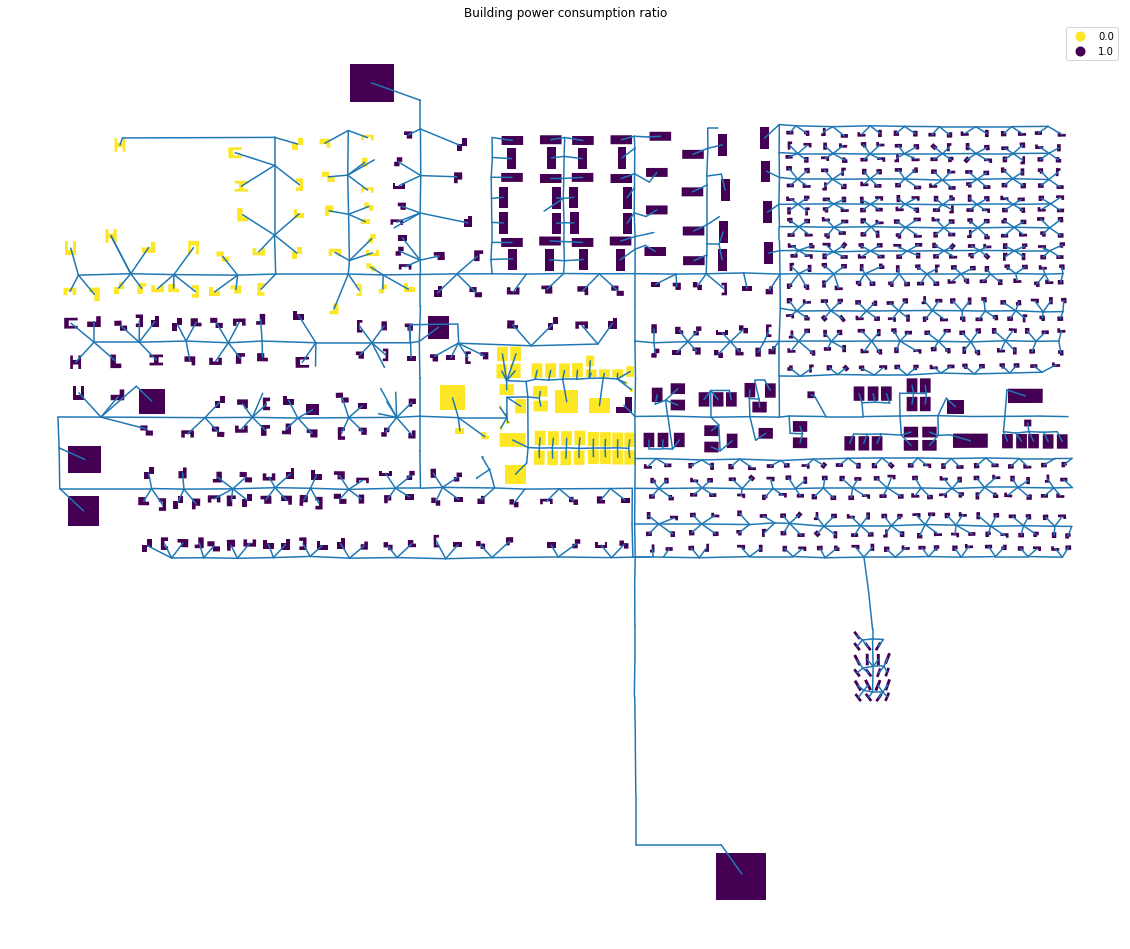

In [510]:
#plotting
fig, ax = plt.subplots(figsize= (20,20)) 
micropolis_links.plot(ax = ax)
micropolis_hub_dist.plot(ax = ax)
micropolis_buildings.plot(ax = ax,
                          column='power_consump_ratio',
                          cmap='viridis_r',
                          categorical = False,
                          legend=True,
                          label = 'Consump'
)

ax.set(title='Building power consumption ratio')
ax.set_axis_off()

# Micropolis Traffic Network Generation

In [39]:
nodes = gpd.read_file(micropolis_folder/'transpo_junctions.shp', encoding="utf-8")
nodes['X'] = round(nodes.centroid.x, 2)
nodes['Y'] = round(nodes.centroid.y,2)
#del nodes['geometry']

ipykernel_launcher:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

ipykernel_launcher:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [40]:
#Trip generation
generate_dict = {
    'Out-City': {'Out-City': [0, 100, 200],
                 'Residentia': [0, 0, 10, 20], 
                 'CBD': [0, 100, 200], 
                 'Outskirts': [0, 10, 15], 
                 'Industrial': [0, 100, 200], 
                 'Indus/CBD': [0, 100, 200]}, 
    'Residentia': {'Out-City': [0, 5, 10], 
                   'Residentia': [0, 0, 5], 
                   'CBD': [0, 10, 20], 
                   'Outskirts': [0, 5, 10], 
                   'Industrial': [0, 20, 50], 
                   'Indus/CBD': [0, 20, 30]}, 
    'CBD': {'Out-City': [0, 50, 100, 150], 
            'Residentia': [0, 5, 10], 
            'CBD': [0, 25, 50, 100], 
            'Outskirts': [0, 10, 20], 
            'Industrial': [0, 50 ,100], 
            'Indus/CBD': [0, 25, 50 , 100]}, 
    'Outskirts': {'Out-City': [0, 5, 10], 
                'Residentia': [0, 0, 5], 
                'CBD': [0, 10, 20],
                'Outskirts': [0, 0 , 10], 
                'Industrial': [0, 10, 20], 
                'Indus/CBD': [0, 10, 20]}, 
    'Industrial': {'Out-City': [0, 100, 150],
                   'Residentia': [0, 0, 5, 10], 
                   'CBD': [0, 50, 100], 
                   'Outskirts': [0, 0, 5, 10], 
                   'Industrial': [0, 100, 150], 
                   'Indus/CBD': [0, 50, 100]},
    'Indus/CBD': {'Out-City': [0, 50, 100], 
                  'Residentia': [0, 0, 5], 
                  'CBD': [0, 25, 50], 
                  'Outskirts': [0, 0, 5], 
                  'Industrial': [0, 50, 100], 
                  'Indus/CBD': [0, 25, 50]}
}

In [41]:
#new attractor columns
attractor_nodes = nodes[nodes['Attractor'] == 1].id.unique()
for col in attractor_nodes:
    nodes[col] = 'NA'

In [42]:
for origin_index, row in nodes.iterrows():
    origin_category = row['Category']
    for attractor_index, attractor in enumerate(attractor_nodes):
        attractor_category = nodes[nodes['id'] == attractor]['Category'].item()
        if row['id'] != attractor:
            nodes.loc[origin_index, attractor] = secrets.choice(generate_dict[origin_category][attractor_category])
        else:
            nodes.loc[origin_index, attractor] = 0
    print(origin_index, end = ", ")
nodes.head()

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 

,id,Category,Attractor,geometry,X,Y,1,2,3,4,...,68,70,72,73,74,75,76,78,79,80
0,1,Out-City,1,POINT (3601.466 1211.461),3601.47,1211.46,0,0,100,100,...,0,100,15,0,200,15,15,20,10,20
1,2,Residentia,1,POINT (3602.095 3218.496),3602.09,3218.50,10,0,20,10,...,5,10,5,50,20,5,5,5,5,0
2,3,CBD,1,POINT (3600.837 3601.537),3600.84,3601.54,100,10,0,0,...,150,50,10,100,100,20,10,5,10,0
3,4,CBD,1,POINT (3604.611 3997.786),3604.61,3997.79,50,10,100,0,...,0,150,20,100,50,20,20,5,5,5
4,5,CBD,1,POINT (3602.095 4422.968),3602.09,4422.97,0,5,0,0,...,150,0,0,0,50,10,10,0,0,10


In [43]:
total_flows = 0
for index, row in nodes.iterrows():
    print('Origin  {}'.format(row['id']))

    for i, attractor in enumerate(attractor_nodes):
        print('    {0} :    {1};'.format(attractor, nodes.loc[index, attractor]), end = '')
        total_flows += nodes.loc[index, attractor]
        
        if (i+1) % 5 == 0:
            print('')
    print('\n')
print(total_flows)

Origin  1
    1 :    0;    2 :    0;    3 :    100;    4 :    100;    5 :    0;
    6 :    20;    7 :    10;    8 :    15;    10 :    200;    14 :    100;
    17 :    15;    18 :    100;    19 :    100;    21 :    0;    22 :    200;
    23 :    0;    29 :    15;    30 :    0;    31 :    100;    32 :    15;
    33 :    10;    35 :    0;    36 :    20;    37 :    20;    38 :    0;
    39 :    10;    46 :    0;    49 :    10;    50 :    20;    55 :    10;
    56 :    10;    57 :    15;    58 :    0;    59 :    15;    60 :    0;
    61 :    0;    62 :    100;    63 :    200;    64 :    200;    68 :    0;
    70 :    100;    72 :    15;    73 :    0;    74 :    200;    75 :    15;
    76 :    15;    78 :    20;    79 :    10;    80 :    20;

Origin  2
    1 :    10;    2 :    0;    3 :    20;    4 :    10;    5 :    10;
    6 :    5;    7 :    5;    8 :    5;    10 :    0;    14 :    0;
    17 :    5;    18 :    5;    19 :    50;    21 :    0;    22 :    20;
    23 :    20;    29 :    5;   

In [44]:
#Node	X	Y	;
node_final = nodes[['id', 'X', 'Y']]
node_final.columns = ['Node', 'X', 'Y']
node_final.to_csv('../dreaminsg_integrated_model/data/networks/micropolis/transportation/nodes_final.csv', sep = '\t', index = False, line_terminator=' ;\n')
node_final.head()

,Node,X,Y
0,1,3601.47,1211.46
1,2,3602.09,3218.50
2,3,3600.84,3601.54
3,4,3604.61,3997.79
4,5,3602.09,4422.97


## Links

In [45]:
links = gpd.read_file(micropolis_folder/'transpo_links.shp', encoding="utf-8")
del links['geometry']
links.id = links.id.astype(int)
links.head()

,id,from,to,Category,Distance
0,1,1,2,Arterial,2.006
1,2,2,3,Arterial,0.382
2,3,3,4,Arterial,0.392
3,4,4,5,Arterial,0.425
4,5,5,6,Arterial,0.375


In [46]:
links_reverse = links.copy(deep=True)
links_reverse['from'] = links['to']
links_reverse['to'] = links['from']

links = links.append(links_reverse)
links.head()

,id,from,to,Category,Distance
0,1,1,2,Arterial,2.006
1,2,2,3,Arterial,0.382
2,3,3,4,Arterial,0.392
3,4,4,5,Arterial,0.425
4,5,5,6,Arterial,0.375


In [47]:
link_dict = {
    'Arterial': {'Capacity': 900*3, 'Free Flow Speed': 50}, 
    'Subarteria': {'Capacity': 800*3, 'Free Flow Speed': 30},
    'Collectors': {'Capacity': 1500, 'Free Flow Speed': 25}
}
delay_dict = {
    'Out-City': 0, 
    'Residentia': 0.5, 
    'CBD': 2, 
    'Outskirts': 0.5, 
    'Industrial': 2,
    'Indus/CBD': 2
}

links['Capacity'] = links["Category"].apply(lambda x: link_dict.get(x)['Capacity'])
links['Free Flow Speed'] = links["Category"].apply(lambda x: link_dict.get(x)['Free Flow Speed'])
links['Free Flow Time1'] = 60*links['Distance']/ links['Free Flow Speed']

links['start_junc_type'] = 'NA'
for index, row in links.iterrows():
    links.loc[index, 'start_junc_type'] = nodes[nodes['id'] == row['from']].Category.values[0]

 
links['Delay'] = links["start_junc_type"].apply(lambda x: delay_dict.get(x))  
links['Free Flow Time'] = round(links['Free Flow Time1'] + links['Delay'],2)

links['B'] = 0.15
links['Power'] = 4
links['Speed limit'] = 0
links['Toll'] = 0
links['Type'] = 1

links_final = links[['from', 'to', 'Capacity', 'Distance', 'Free Flow Time', 	'B', 'Power', 'Speed limit', 'Toll', 'Type']]
links_final.columns = ['Init node',	'Term node', 'Capacity', 'Length', 'Free Flow Time',	'B', 'Power', 'Speed limit', 'Toll', 'Type']

links_final.to_csv('../dreaminsg_integrated_model/data/networks/micropolis/transportation/links_final.csv', sep = '\t', index = False, line_terminator=' ;\n')
links_final.head()

,Init node,Term node,Capacity,Length,Free Flow Time,B,Power,Speed limit,Toll,Type
0,1,2,2700,2.006,2.91,0.15,4,0,0,1
1,2,3,2700,0.382,2.46,0.15,4,0,0,1
2,3,4,2700,0.392,2.47,0.15,4,0,0,1
3,4,5,2700,0.425,2.51,0.15,4,0,0,1
4,5,6,2700,0.375,0.95,0.15,4,0,0,1


In [48]:
print(node_final.Node.unique().size)
print(links_final.shape)

80
(240, 10)
